# EXAM May 24 - June 7, 2024 - part 1

## Imports, constants and general functions

### Imports / basic setup

In [45]:
import logging
import threading
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.decomposition import PCA
from sklearn.preprocessing import StandardScaler

In [46]:
%matplotlib inline
random_state = 42
np.random.seed(random_state)
print_lock = threading.Lock()
sns.set_style(style="darkgrid")

logging.basicConfig(level=logging.INFO, format='%(asctime)s - %(message)s')

### Constants

In [47]:
scaler = StandardScaler()

### Functions

In [48]:
def splits(X, Y, test_size=0.2, validation_set=False, validation_size=0.2):
    """
    Split the input data into training, validation, and test sets.

    Parameters:
    - X (array-like): The input features.
    - Y (array-like): The target variable.
    - test_size (float, optional): The proportion of the data to include in the test set. Default is 0.2.
    - validation_set (bool, optional): Whether to include a validation set. Default is False.
    - validation_size (float, optional): The proportion of the data to include in the validation set. Default is 0.2.

    Returns:
    - If validation_set is False:
        - X_train (array-like): The training features.
        - X_test (array-like): The test features.
        - Y_train (array-like): The training target variable.
        - Y_test (array-like): The test target variable.
    - If validation_set is True:
        - X_train (array-like): The training features.
        - X_val (array-like): The validation features.
        - X_test (array-like): The test features.
        - Y_train (array-like): The training target variable.
        - Y_val (array-like): The validation target variable.
        - Y_test (array-like): The test target variable.
    """
    X_train, X_test, Y_train, Y_test = train_test_split(X, Y, test_size=test_size, random_state=random_state, stratify=Y)
    
    if validation_set:
        X_train, X_val, Y_train, Y_val = train_test_split(X_train, Y_train, test_size=validation_size, random_state=random_state, stratify=Y_train)
        return X_train, X_val, X_test, Y_train, Y_val, Y_test
    
    return X_train, X_test, Y_train, Y_test

## Reading data

In [49]:
# read cancer data
X_fish = pd.read_csv('../data/Fish3.txt', delimiter=' ', index_col=0, header=0)
Y_fish = X_fish.pop('Species')

# split data
X_train_fish, X_test_fish, Y_train_fish, Y_test_fish = splits(X_fish, Y_fish, test_size=0.2, validation_set=False)

In [50]:
print(X_train_fish.shape, Y_train_fish.shape)

(1492, 6) (1492,)


In [51]:
print('Features Fish dataset:')
display(X_train_fish.head())

print('Target Fish dataset:')
display(pd.DataFrame(Y_train_fish).head())

Features Fish dataset:


,Weight,L1,L2,L3,Height,Width
529,709.630849,32.430453,36.221668,40.405437,26.470550,15.908108
1502,303.170884,23.836900,29.396465,29.594531,28.249178,17.772166
1140,320.456136,25.545334,27.804389,35.310973,37.634905,13.230648
1857,505.210081,28.783756,30.849799,36.764497,39.789060,14.002247
598,384.723812,35.802118,37.048835,39.602860,18.613225,11.194776


Target Fish dataset:


,Species
529,Perch
1502,Perch
1140,Bream
1857,Bream
598,Pike


In [52]:
# create a mapping of the classes to integers
class_mapping = {label: idx for idx, label in enumerate(np.unique(Y_train_fish))}

# Y_fish = Y_fish.map(class_mapping)
# display(pd.DataFrame(Y_fish).head())

In [53]:
# check for missing values
print('Missing values in Fish dataset:')
display(X_train_fish.isnull().sum())

Missing values in Fish dataset:


Weight    0
L1        0
L2        0
L3        0
Height    0
Width     0
dtype: int64

## Exploratory data analysis (EDA)

Class distribution:


,count,percentage
Species,,
Bream,433,0.290214
Perch,299,0.200402
SilverBream,193,0.129357
Pike,189,0.126676
Smelt,175,0.117292
Roach,170,0.113941
Whitewish,33,0.022118


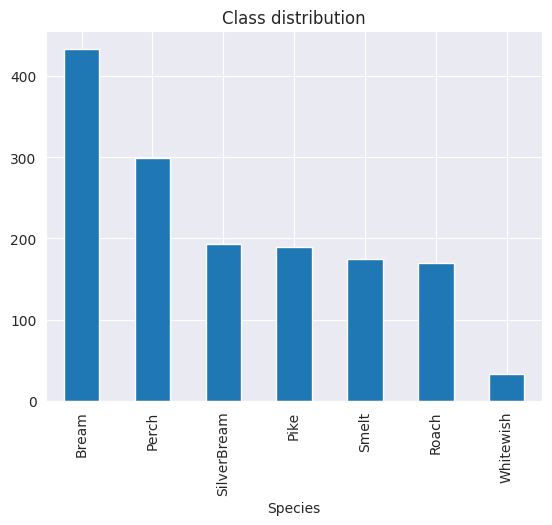

In [54]:
# check for class imbalance
print('Class distribution:')
display(pd.DataFrame({'count': Y_train_fish.value_counts(), 'percentage': Y_train_fish.value_counts(normalize=True)}))

# bar plot of class distribution
Y_train_fish.value_counts().plot(kind='bar', title='Class distribution')
plt.show()

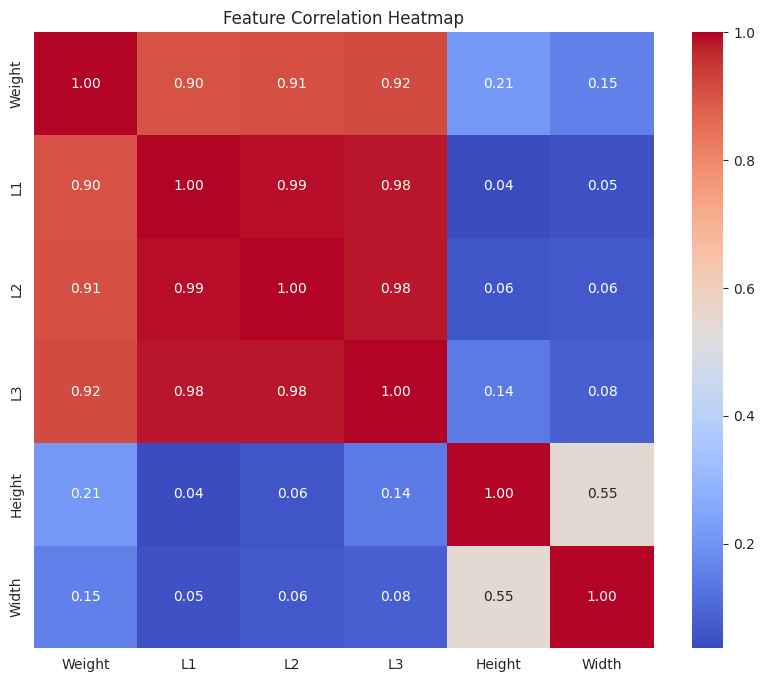

In [55]:
# check the feature correlation
corr_matrix = X_train_fish.corr()
plt.figure(figsize=(10, 8))
plt.title('Feature Correlation Heatmap')
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.show()

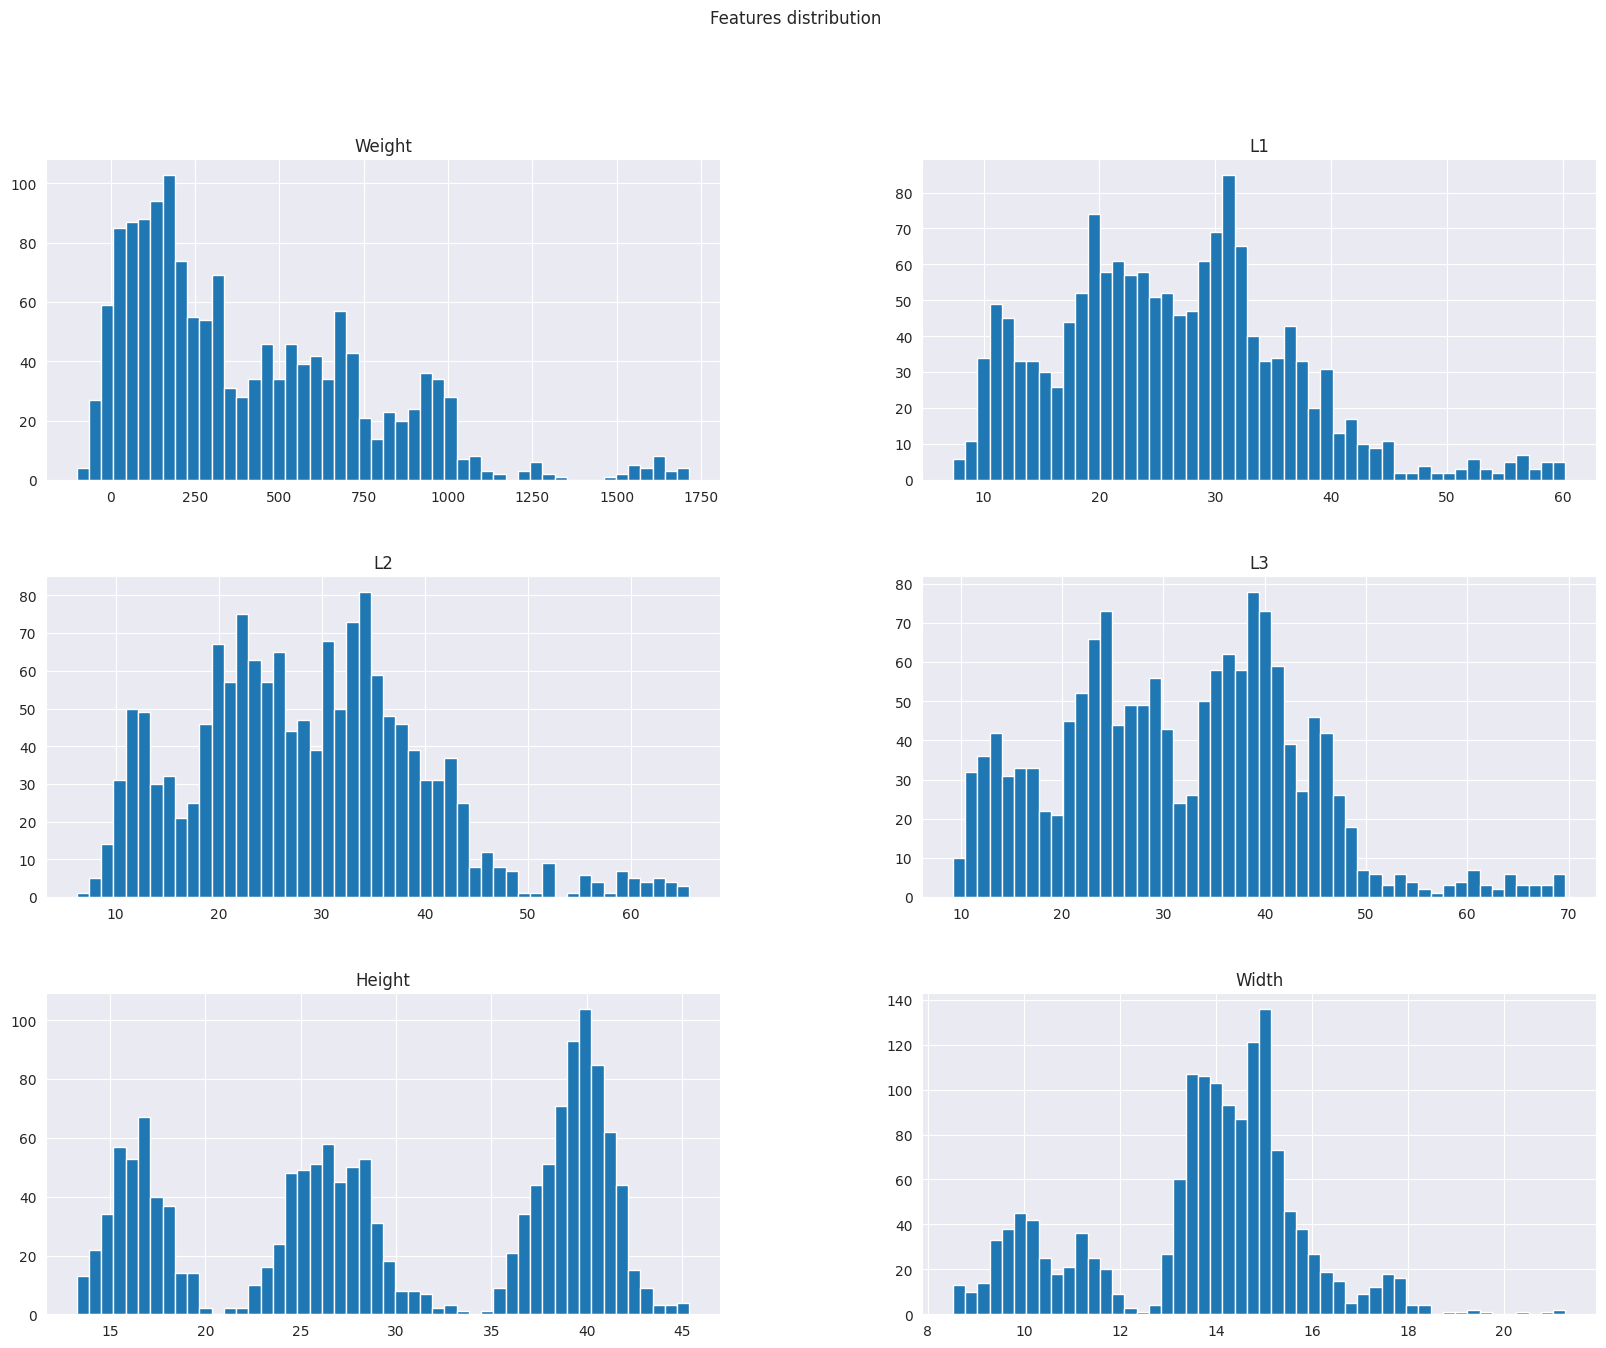

In [56]:
# features distribution
X_train_fish.hist(bins=50, figsize=(20, 15))
plt.suptitle('Features distribution')
plt.show()

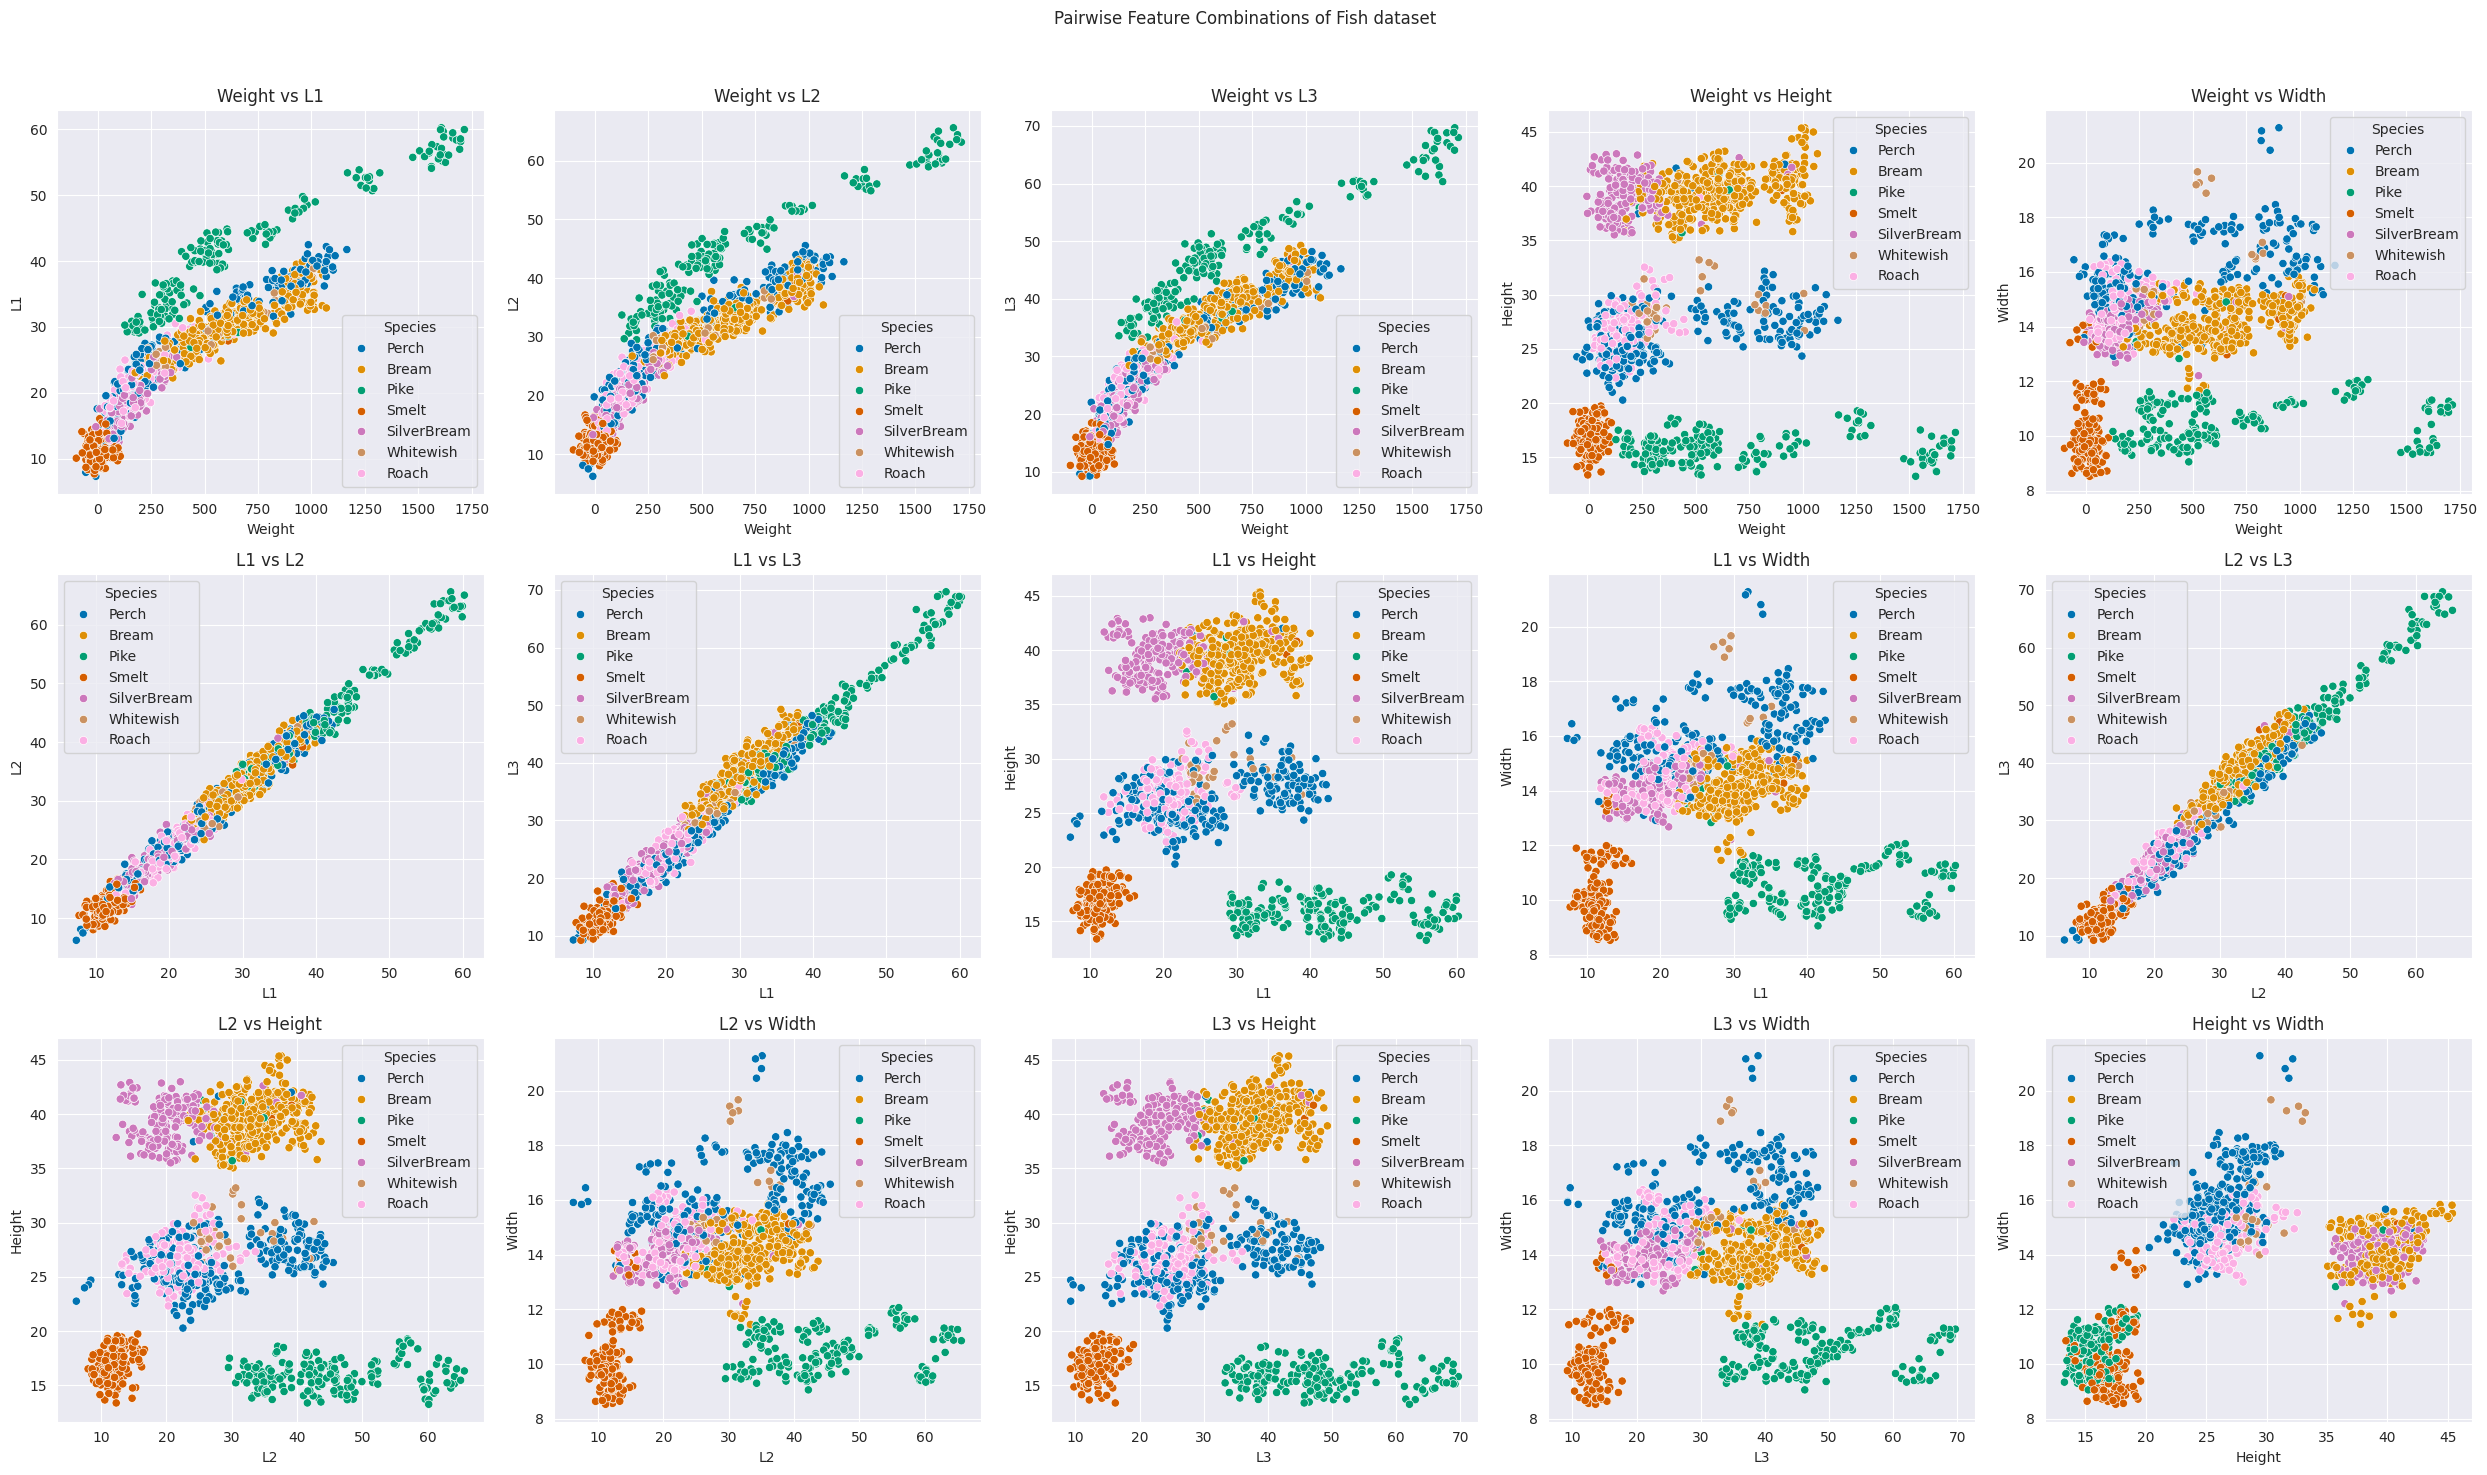

In [57]:
# Assuming X_fish and Y_fish are your data and labels
import itertools


feature_names = X_fish.columns  # Assuming X_fish is a DataFrame with named columns

# Generate all pairs of features
feature_pairs = list(itertools.combinations(range(len(feature_names)), 2))

# Plotting
num_rows = 3
num_cols = 5
fig, axes = plt.subplots(num_rows, num_cols, figsize=(25, 15))
fig.suptitle('Pairwise Feature Combinations of Fish dataset')

for ax, (i, j) in zip(axes.flatten(), feature_pairs):
    sns.scatterplot(x=X_train_fish.iloc[:, i], y=X_train_fish.iloc[:, j], hue=Y_train_fish, palette='colorblind', ax=ax)
    ax.set_xlabel(feature_names[i])
    ax.set_ylabel(feature_names[j])
    ax.set_title(f'{feature_names[i]} vs {feature_names[j]}')

# Remove any empty subplots
for k in range(len(feature_pairs), num_rows * num_cols):
    fig.delaxes(axes.flatten()[k])

plt.tight_layout(rect=[0, 0, 1, 0.96])
plt.show()

## 1a: training and prediction perormance

Reasons why in all the models `class_weight = True`:
- Small weights result in a small penalty and a small update to the model coefficients
- Large weights result in a large penalty and a large update to the model coefficients

In [94]:
import numpy as np
import pandas as pd
from sklearn.model_selection import RepeatedStratifiedKFold, cross_val_predict, cross_val_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.neural_network import MLPClassifier
from sklearn.pipeline import Pipeline, make_pipeline
from sklearn.svm import SVC
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import ConfusionMatrixDisplay, classification_report, confusion_matrix, f1_score, make_scorer
import math

# Define models to compare
models = {
    'Logistic Regression': LogisticRegression(max_iter=1000, class_weight='balanced'),
    'Random Forest': RandomForestClassifier(class_weight='balanced'),
    'Gradient Boosting': GradientBoostingClassifier(),
    'Support Vector Machine': SVC(class_weight='balanced'),
    'K-Nearest Neighbors': KNeighborsClassifier(),
    'Decision Tree': DecisionTreeClassifier(class_weight='balanced'),
    # 'Multilayer Perceptron': MLPClassifier(early_stopping=True, n_iter_no_change=10)
}

# Define cross-validation strategy
cv = RepeatedStratifiedKFold(n_splits=5, n_repeats=5, random_state=42)

def plot_confusion_matrix(Y_test, Y_pred, labels, model_name, key, flag_plot):
  # confusion matrix and display
  cm = confusion_matrix(Y_test, Y_pred)
  cm_display = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=labels)
  
  # plot the confusion matrix
  cm_display.plot()
  plt.title(f'Confusion matrix for test data (model: {model_name})')
  plt.savefig(f'imgs/{key}/CM_{model_name}.png')
  if flag_plot:
    plt.show()

# Function to evaluate models and generate classification reports
def evaluate_models(X_train, y_train, X_test, y_test, models, cv):
    cv_results = {}
    # cv_reports = {}
    
    test_results = {}
    test_reports = {}

    for name, model in models.items():
        model_pipeline = Pipeline(steps=[('scaler', StandardScaler()), ('model', model)])
        
        # Evaluate model using cross_val_predict to get predictions
        # y_pred_cv = cross_val_predict(model_pipeline, X_train, y_train, cv=cv, n_jobs=-1)
        
        # Store cv f1-score results
        f1_cv = cross_val_score(model_pipeline, X_train, y_train, scoring='f1_macro', cv=cv, n_jobs=-1)
        cv_results[name] = f1_cv
        print(f'{name}: Mean F1 = {f1_cv.mean():.3f} (Std = {f1_cv.std():.3f})')

        # Generate cv classification report
        # report = classification_report(y_train, y_pred_cv, target_names=np.unique(y_train), output_dict=True)
        # cv_reports[name] = pd.DataFrame(report).transpose()
                
        # Fit the model on the training data
        model_pipeline.fit(X_train, y_train)
        y_pred_test = model_pipeline.predict(X_test)
        
        # store test f1-score results
        f1_test = f1_score(y_test, y_pred_test, average='macro')
        test_results[name] = [f1_test]
        print(f'{name}: Test F1 = {f1_test:.3f}')
        
        # Generate test classification report
        report = classification_report(y_test, y_pred_test, target_names=np.unique(y_test))
        test_reports[name] = report

    return cv_results, test_results, test_reports

def plot_results(results, title='Model Comparison', ylabel='F1 Score'):
    plt.figure(figsize=(10, 6))
    plt.boxplot(results.values(), labels=results.keys(), showmeans=True)
    plt.title(title)
    plt.ylabel(ylabel)
    plt.xticks(rotation=45)
    plt.show()
    
def display_reports(reports):
    for model_name, report in reports.items():
        print(f"\nClassification Report for {model_name}:\n")
        print(report)

In [95]:
# Evaluate models
cv_results, test_results, test_reports = evaluate_models(X_train_fish, Y_train_fish, X_test_fish, Y_test_fish, models, cv)

Logistic Regression: Mean F1 = 0.743 (Std = 0.024)
Logistic Regression: Test F1 = 0.797
Random Forest: Mean F1 = 0.870 (Std = 0.027)
Random Forest: Test F1 = 0.871
Gradient Boosting: Mean F1 = 0.828 (Std = 0.028)
Gradient Boosting: Test F1 = 0.890
Support Vector Machine: Mean F1 = 0.789 (Std = 0.027)
Support Vector Machine: Test F1 = 0.825
K-Nearest Neighbors: Mean F1 = 0.887 (Std = 0.022)
K-Nearest Neighbors: Test F1 = 0.923
Decision Tree: Mean F1 = 0.816 (Std = 0.028)
Decision Tree: Test F1 = 0.838


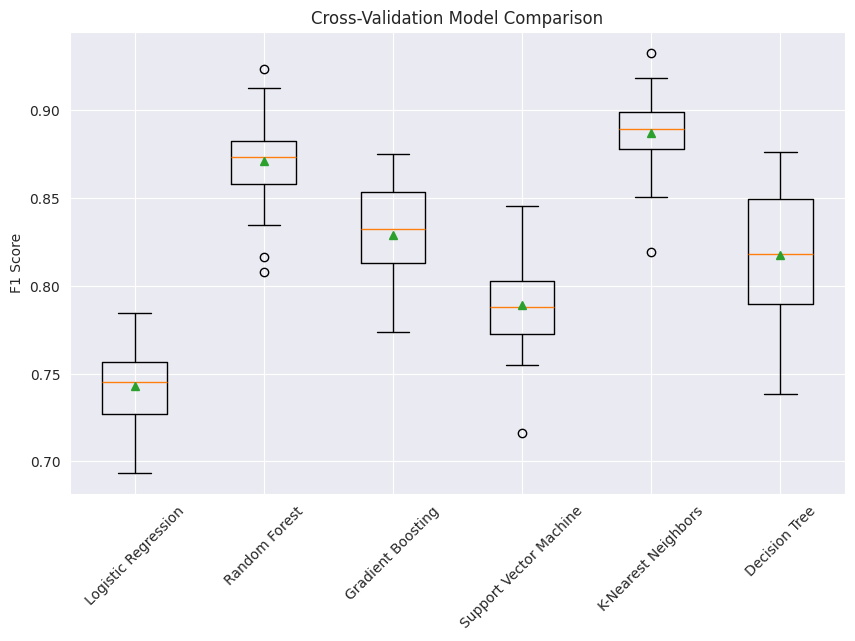

In [85]:
# Plot cv results
plot_results(cv_results, title='Cross-Validation Model Comparison')

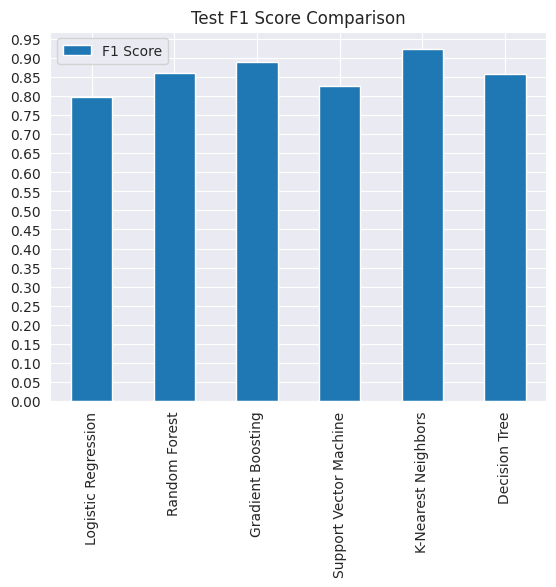

In [92]:
# plot test results with a bar plot
test_results_df = pd.DataFrame(test_results).transpose()
test_results_df.columns = ['F1 Score']
test_results_df.plot(kind='bar', title='Test F1 Score Comparison')
plt.yticks(np.arange(0, 1.0, 0.05))
plt.show()

In [ ]:
# Display cv classification reports
# plot_reports(cv_reports)

In [96]:
# display test classification reports
display_reports(test_reports)


Classification Report for Logistic Regression:

              precision    recall  f1-score   support

       Bream       0.93      0.94      0.93       109
       Perch       0.94      0.60      0.73        75
        Pike       1.00      1.00      1.00        47
       Roach       0.60      0.76      0.67        42
 SilverBream       0.89      0.96      0.92        49
       Smelt       1.00      0.95      0.98        44
   Whitewish       0.24      0.62      0.34         8

    accuracy                           0.86       374
   macro avg       0.80      0.83      0.80       374
weighted avg       0.89      0.86      0.86       374


Classification Report for Random Forest:

              precision    recall  f1-score   support

       Bream       0.92      1.00      0.96       109
       Perch       0.86      0.83      0.84        75
        Pike       1.00      1.00      1.00        47
       Roach       0.78      0.76      0.77        42
 SilverBream       1.00      0.94      0